# Interactive dEB light curve "quick" fitting tool

In [4]:
# A vain attempt to suppress excessive TF info/warn messages
%env TF_CPP_MIN_LOG_LEVEL 2

env: TF_CPP_MIN_LOG_LEVEL=2


In [5]:
import sys
from pathlib import Path
import re
from ast import literal_eval
import warnings
import copy

import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from mocpy import MOC
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
import lightkurve as lk

warnings.filterwarnings("ignore", "Using UFloat objects with std_dev==0 may give unexpected results.", category=UserWarning)
from uncertainties import UFloat, ufloat
from uncertainties.unumpy import nominal_values

#%matplotlib widget 
import matplotlib.pyplot as plt

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *
from ipyaladin import Aladin, Marker

# Dereddening of SEDS
from dust_extinction.parameter_averages import G23

# MCMC for SEDS
import corner

from sed_fit.stellar_grids import get_stellar_grid
from sed_fit.fitter import create_theta, model_func, minimize_fit, mcmc_fit, samples_from_sampler, median_and_quantile_values

from deblib.constants import G, R_sun, M_sun
from ebop_maven.estimator import Estimator
from libs import lightcurves, pipeline, plots, extinction
from libs.targets import Targets
from libs.pipeline import nominal_value
from libs.catalogues import query_tess_ebs_ephemeris, estimate_eclipse_durations_from_morphology, query_tess_ebs_in_sh
from libs.sed import get_sed_for_target, group_and_average_fluxes, create_outliers_mask

# The eclipse completeness ratio above which eclipses are considered complete
ECLIPSE_COMPLETE_TH = 0.9

# The morph value for systems considered very well detached & from which we invoke flattening & clip
FLATTEN_TH = 0.2

In [6]:
gaia_tbosb_catalog = Vizier(catalog="I/357/tbosb2", row_limit=1)
estimator = Estimator()

Estimator loading '/home/steveo/projects/main/modebs/.modebs/lib/python3.11/site-packages/ebop_maven/data/estimator/default-model.keras'...loaded 'CNN-Rev1-Ext0-bP-4096-None-1000k'.
The model CNN-Rev1-Ext0-bP-4096-None-1000k was created at 2025-09-18T18:21:13+00:00
The input features are:
  mags_feature as a NDarray[float] of shape (#instances, 4096) containing a phase folded light curve centred on the mid-point between the primary and secondary eclipse
  extra_features as a NDarray of shape (#instances, 0) or None, as no extra_features are used for predictions
The prediction results are:
  predicted values as a structured NDarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
  optionally, if include_raw is True, all MC predictions as a NDArray[float] of shape (#instances, 6, #iterations)


### Select the target 
There are currently 2 sets of configured targets, configured in corresponding
/config/*-explicit-targets.json file:
- a set of approximately 25 test systems with existing full characterisations, taken from DEBCAT
- a set of systems identified for characterisation that are in both the Plato LOPS2 field and
the TESS-ebs catalogue

For each target we specify the object name value used on plots, messages and local cache folder.
The search term is used to search for assets in MAST, which can be the target name
(with or without a V* prefix) or a TIC identifier (9 digit numeric value).

In [7]:
# This section is based on the targets being a subset of the TESS-ebs catalogue
# targets_config = Targets("config/plato-lops2-tess-ebs-targets.json")

# Explicit set of targets - we want these systems only
# targets_config = Targets("config/plato-lops2-tess-ebs-explicit-targets.json")

# Explicit set of test targets with known characterisation - we want these systems only
targets_config = Targets("config/formal-test-explicit-targets.json")

if _target_ids := targets_config.get_known_target_ids(omit_excluded=True):
    print(f"Using {len(_target_ids)} explicitly configured target(s) within the config json.")
    target_ops = [(f"{t}", targets_config.get(t).get("search_term", t)) for t in _target_ids]
else:
    # MOC (multi-order coverage map) for querying the full LOPS2 field (regardless of the ncam coverage)
    # Get all targets common to both LOPS2 and the source catalogue and TESS-ebs
    _lops_moc = MOC.load(path="libs/data/lops2-footprints-moc/PLATOfootprint_hpix9_full_v2.fits")
    _all_tebs_lops = _lops_moc.query_vizier_table("J/ApJS/258/16")
    _all_tebs_lops.sort("TIC")

    # We want to select only those targets within the TESS-ebs morphology and/or period criteria.
    _tebs_mask = np.ones(len(_all_tebs_lops), dtype=bool)
    for _field, _filter in [("Morph", [0, 0.6]), ("Per", [0, np.inf])]:   
        _tebs_mask &= (_all_tebs_lops[_field] >= min(_filter)) & (_all_tebs_lops[_field] <= max(_filter))

    print(f"Found {len(_all_tebs_lops)} targets from the TESS-ebs catalog within the LOPS2 field.",
        f"\n{sum(_tebs_mask)} remain after applying of morphology, period and exclusion criteria.")
    target_ops = [(f"{t['TIC']} (Morph={t['Morph']:.3f}; Per={t['Per']:.3f} d)", t['TIC']) for t in _all_tebs_lops[_tebs_mask]]

Using 26 explicitly configured target(s) within the config json.


In [8]:
_default_target = "HP Dra"
if not _default_target in [t[1] for t in target_ops]:
    _default_target = target_ops[0][1]

display(VBox(children=[
    (_tebs_targs := Dropdown(description="Targets :", options=target_ops, value=_default_target, layout={'width': "max-content"})),
    HBox(children=[
        (target_text := Text(description="Target :", value="", placeholder="name or TIC")),
        (do_prefix := Checkbox(description="prefix non-numeric search term with V*", value=True, layout={'width': "max-content"} )),
    ]),
]))

dlink((_tebs_targs, 'value'), (target_text, 'value'))

### Review Target Information
Gather published information on the chosen target from various sources:
- SIMBAD for the target's alternative identifiers, spectral type and coordinates
- Gaia DR3 for revised coordinates
- the TESS-ebs catalogue for target's ephemeris and morphology

In [9]:
target = f"TIC {int(target_text.value):d}" if target_text.value.isnumeric() else target_text.value
target_config = targets_config.get(target_text.value, fallback_to_default=True)
target_meta = {
    "target": target,
    "search_term": f"V* {target}" if not target.startswith("TIC") and do_prefix.value else target,
    "morph": 0.5,
    "phiS": 0.5
}

print(f"The chosen target is '{target}' with search_term '{target_meta['search_term']}'")

target_coords = None
_simbad = Simbad()
_simbad.server = "simbad.cds.unistra.fr" # 'simbad.cds.unistra.fr' | 'simbad.harvard.edu' rather unreliable
_simbad.add_votable_fields("parallax", "sp", "ids")
if (_tbl := _simbad.query_object(target_meta["search_term"])):
    target_ids = np.array(re.findall(r"(Gaia DR3|V\*|TIC|HD|HIP|2MASS)\s+(.+?(?=\||$))", _tbl["ids"][0]),
                                         dtype=[("type", object), ("id", object)])
    print(f"AKA:       ",
          ", ".join(id for i in target_ids if (id:=f"{i[0]} {i[1]}") not in [target_meta["search_term"], target]))
    target_meta["tics"] = list(target_ids[target_ids["type"]=="TIC"]["id"])
    target_meta["tics"] += [target] if target.startswith("TIC") else []

    target_meta["coords"] = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit, dec=_tbl["dec"][0] * _tbl["dec"].unit,
                                     distance=1000 / _tbl["plx_value"][0] * u.pc)
    target_meta["SpT"] = _tbl["sp_type"][0]
    print(f"SpT:       ", target_meta["SpT"], f"\nCoords:    ", f"{target_meta['coords']}",
          f"[qual='{_tbl['plx_qual'][0]}', ref='{_tbl['plx_bibcode'][0]}']")

# If the target is in Gaia DR3 we can override the skycoords
if "Gaia DR3" in target_ids["type"] and (_gaia_dr3_id := target_ids[target_ids["type"] == "Gaia DR3"]["id"][0]):
    if (_job := Gaia.launch_job(f"SELECT TOP 1 * FROM gaiadr3.gaia_source WHERE source_id = {_gaia_dr3_id}")):
        _tbl = _job.get_results()
        if _tbl["parallax"][0] and _tbl["parallax"] > 0:
            target_meta["coords"] = SkyCoord(ra=_tbl["ra"][0] * u.deg, dec=_tbl["dec"][0] * u.deg,
                                             distance=1000 / _tbl["parallax"][0] * u.pc, frame="icrs")
            print(f"DR3 Coords:", f"{target_meta['coords']}")
        elif target_coords:
            print(f"DR3 Coords: parallax missing or <0 so sticking with SIMBAD coords")
        print(f"DR3 ruwe:   {_tbl['ruwe'][0]:.3f} [rows={len(_tbl)}]")
    else:
        print(f"\033[93m\033[1mTarget {target} not found in Gaia DR3.\033[0m")

if (_tebs_data := query_tess_ebs_ephemeris(target_meta["tics"], target_config.period_factor)) is not None:
    for k in _tebs_data: # Override where TESS-ebs has data
        target_meta[k] = _tebs_data.get(k, None) or target_meta.get(k, None)
else:
    print(f"\033[93m\033[1mTarget {target} not found in TESS-ebs.\033[0m")

# Set these target data (potentially overriding values from lookup above) if they're in the target config
for k in ["t0", "period", "morph", "Teff_sys", "logg_sys", "durP", "durS", "depthP",  "depthS", "phiP", "phiS"]:
    target_meta[k] = target_config.get(k, None) or target_meta.get(k, None)

if target_meta.get("durP", None) is None or target_meta.get("durS", None) is None:
    print(f"\033[93m\033[1mEclipse duration data missing. Will use estimated values based on morph\033[0m")
    target_meta["durP"], target_meta["durS"] \
        = estimate_eclipse_durations_from_morphology(target_meta["morph"], target_meta["period"])

print("Ephemeris: ",
      ", ".join(f"{k}=" + ("None" if target_meta.get(k, None) is None else (f"{{0:.{dp}f}}".format(target_meta[k])))
                for k, dp in [("t0",6), ("period",6), ("morph", 3), ("phiS",3), ("durP",3), ("durS",3), ("depthP",3), ("depthS",3)]))

if (_tbl := gaia_tbosb_catalog.query_object(target_meta["search_term"], radius=5. * u.arcsec)):
    print(f"Gaia TBOSB: period={_tbl[0]['Per'][0]:.6f} d, ecc={_tbl[0]['ecc'][0]:.6f},",
            f"omega={_tbl[0]['omega'][0]:.6f}, K1={_tbl[0]['K1'][0]:.6f}, K2={_tbl[0]['K2'][0]:.6f} [rows={len(_tbl)}]")
    if abs(nominal_value(target_meta["period"]) - _tbl[0]['Per'][0]) > nominal_value(target_meta["period"] * 0.1):
        print("\033[93m\033[1mTBOSB period differs significantly from TESS-ebs/config\033[0m")

The chosen target is 'HP Dra' with search_term 'V* HP Dra'
AKA:        TIC 48356677, HIP 92835, Gaia DR3 2144465183642116864, HD 175900, 2MASS J18545347+5118298
SpT:        G5 
Coords:     <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (283.72283764, 51.30827552, 79.26882436)> [qual='A', ref='2020yCat.1350....0G']
DR3 Coords: <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (283.72300282, 51.30864577, 79.26861318)>
DR3 ruwe:   1.644 [rows=1]
Ephemeris:  t0=1692.939857+/-0.002406, period=10.761463+/-0.000083, morph=0.142, phiS=0.517, durP=0.313+/-0.000, durS=0.326+/-0.000, depthP=0.227, depthS=0.206


### Locate and open the target's light curves
Now find and list the available light curves for the target. Pre-selections can be set up with the
`sectors` and `exclude_sectors` items in the target's configuration.
If no sector configuration is found, all light curves will be selected by default.

In [10]:
# Get all of the data for this target.
# It's quicker to do this once and cache the results, then not bother MAST again.
lcs = lightcurves.load_lightcurves(target, target_meta["search_term"], sectors=None,
                                   mission=target_config.mission, author=target_config.author, exptime=target_config.exptime,
                                   quality_bitmask=target_config.quality_bitmask, flux_column=target_config.flux_column,
                                   force_mast=False, cache_dir=Path() / ".cache/", verbose=True)

# Then filter out any results that are for a different TIC (unlikely).
if not all(_tic_mask := np.in1d([f"{l.meta['TARGETID']}" for l in lcs], target_ids[target_ids["type"]=="TIC"]["id"])):
    lcs = lcs[_tic_mask]

# Make configured selections. Process exclusions first so they're overidden by mention in sectors.
_selected = np.ones(len(lcs), dtype=bool)
if len((exclude_sectors := target_config.exclude_sectors) or []) > 0:
    _selected = np.in1d(lcs.sector, exclude_sectors, invert=True)
if len((sectors_flat := target_config.sectors_flat) or []) > 0:
    _selected = np.in1d(lcs.sector, sectors_flat)

# Give user a chance to override any pre-selection of sectors
_target_box = Accordion(
    children=[
        VBox(children=(sec_checks := 
            [Checkbox(description="toggle all", value=True, indent=False)] + 
            [Checkbox(description=f"Sector {l.sector:02d} @ {l.meta['FRAMETIM']*l.meta['NUM_FRM']} s ({l.meta['MISSION']}, {l.meta['AUTHOR']}, pdc_tot={l.meta['PDC_TOT']:.3f})",
                      value=bool(chk), indent=False, layout={'width': "max-content"}) for l, chk in zip(lcs, _selected)]
        )),
    ],
    titles=[f"The {len(lcs)} lightcurve(s) found for {target}"],
    selected_index=0)

def toggle_all(_):
    for cb in sec_checks[1:]: cb.value = sec_checks[0].value
sec_checks[0].observe(toggle_all)
display(_target_box)

Searching for light curves for search term='V* HP Dra', sectors=None, mission=['TESS', 'HLSP'], author=['SPOC', 'TESS-SPOC'] and exptime=short
Loaded previously cached search results matching these criteria.


Accordion(children=(VBox(children=(Checkbox(value=True, description='toggle all', indent=False), Checkbox(valu…

The selected light curves are opened. For details of the flux_column and quality_bitmask
arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download).
The load_lightcurves() function will attempt to service the request from the local cache in
preference to contacting MAST.

In [11]:
_select_mask = np.array([sec_checks[i].value for i in range(1, len(sec_checks))], dtype=bool)
lcs = lcs[_select_mask]

Now pre-process the selected light curves. This involves:
- clipping invalid fluxes and isolated regions of the light curves
- locating and inspecting the eclipses for completeness and refining the eclipse timings
sector by sector 
- generating a plot of light curves' normalized fluxes for inspection

Finding (pri, sec) eclipses in sector 14 with min duration 0.313 & 0.326 [d] and min depth 0.15 & 0.136 [norm flux]...found 1 & 2 eclipse(s) with fluxes.
Finding (pri, sec) eclipses in sector 15 with min duration 0.313 & 0.326 [d] and min depth 0.15 & 0.136 [norm flux]...found 2 & 2 eclipse(s) with fluxes.
Finding (pri, sec) eclipses in sector 26 with min duration 0.313 & 0.326 [d] and min depth 0.15 & 0.136 [norm flux]...found 2 & 3 eclipse(s) with fluxes.
Finding (pri, sec) eclipses in sector 40 with min duration 0.313 & 0.326 [d] and min depth 0.15 & 0.136 [norm flux]...found 3 & 2 eclipse(s) with fluxes.
Finding (pri, sec) eclipses in sector 41 with min duration 0.313 & 0.326 [d] and min depth 0.15 & 0.136 [norm flux]...found 3 & 2 eclipse(s) with fluxes.
Finding (pri, sec) eclipses in sector 53 with min duration 0.313 & 0.326 [d] and min depth 0.15 & 0.136 [norm flux]...found 3 & 2 eclipse(s) with fluxes.
Finding (pri, sec) eclipses in sector 54 with min duration 0.313 & 0.326 [d]

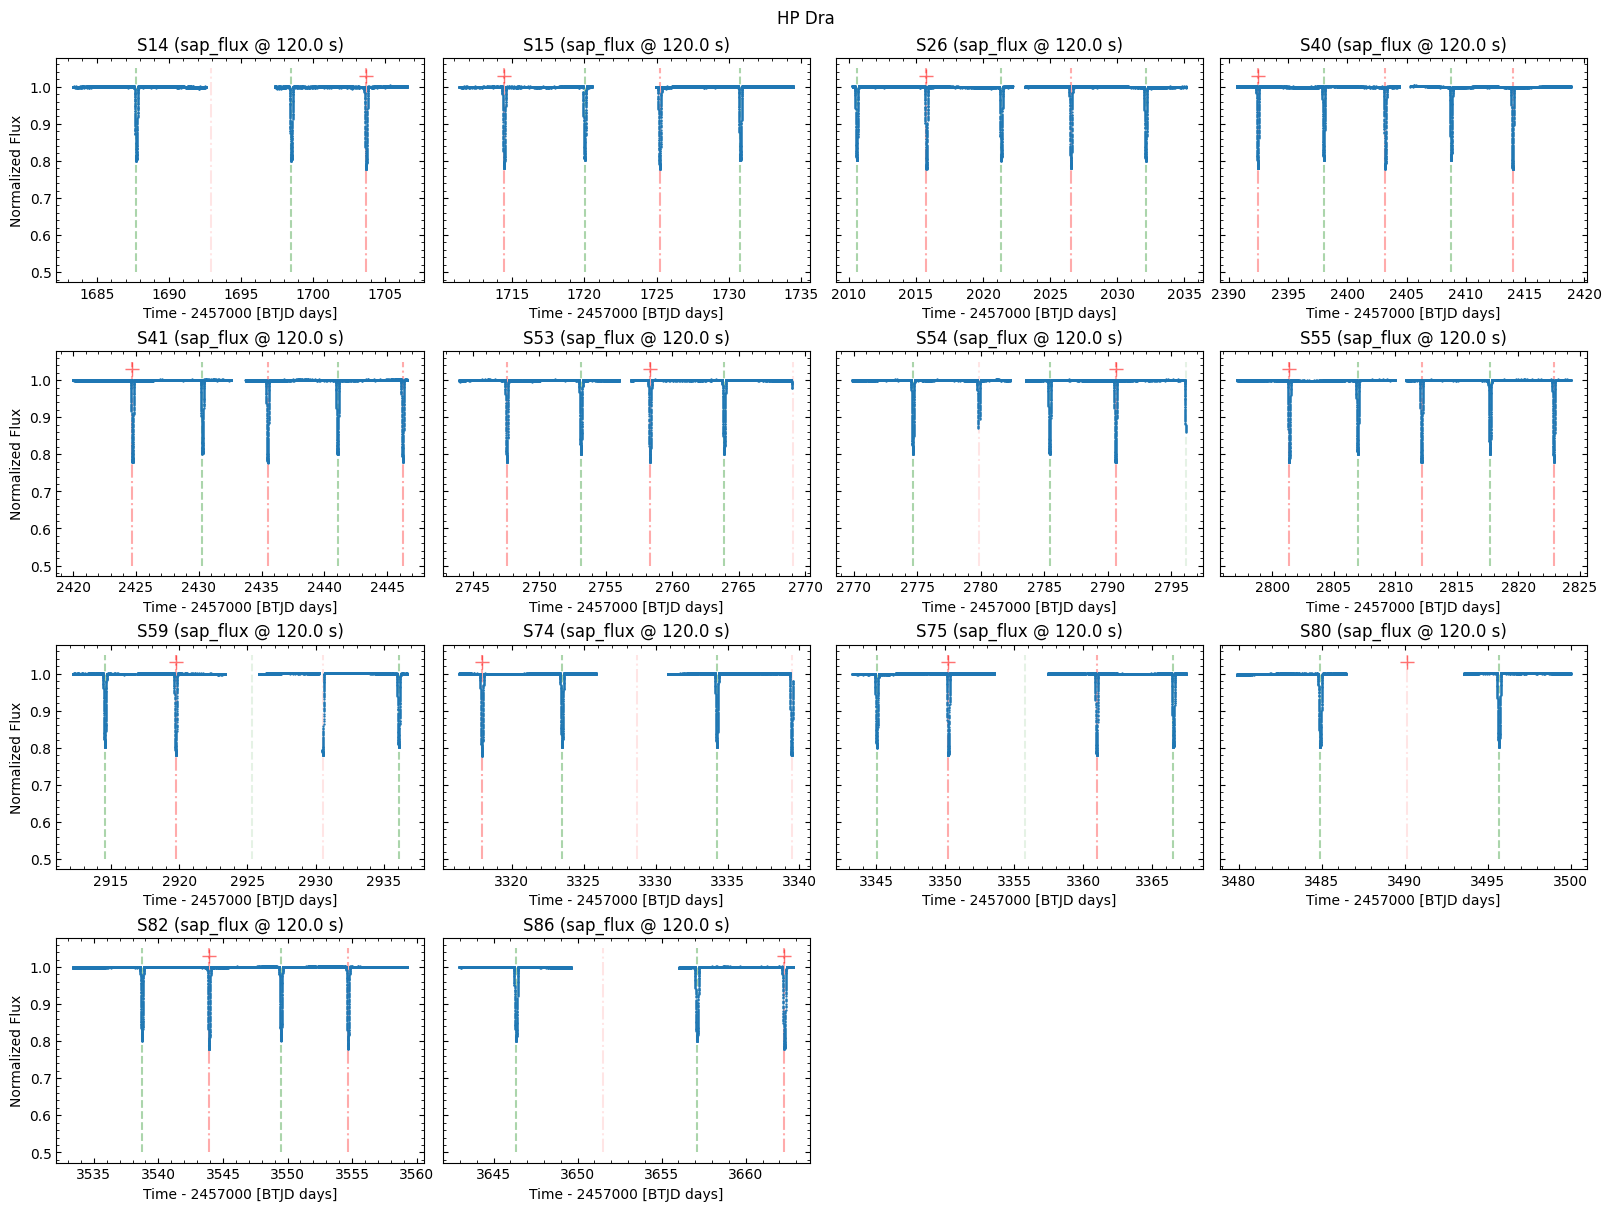

In [12]:
# Mask out any invalid fluxes, known distorted sections or isolated sections < 2 d long
pipeline.mask_lightcurves_unusable_fluxes(lcs, target_config.quality_masks or [])

# Sets primary|secondary _times & _completeness arrays and t0 ('best' primary) in each LC's metadata
pipeline.add_eclipse_meta_to_lightcurves(lcs,
                                         nominal_value(target_meta["t0"]),
                                         target_meta["period"],
                                         target_meta["durP"],
                                         target_meta["durS"],
                                         target_meta["depthP"],
                                         target_meta["depthS"],
                                         target_meta["phiS"],
                                         verbose=True)

def _indicate_eclipses(_, ax, lc):
    for ecl_type, ls, c in [("secondary", "--", "g"), ("primary", "-.", "r")]:
        alphas = [0.33 if cf else 0.1 for cf in lc.meta[f"{ecl_type}_completeness"] >= ECLIPSE_COMPLETE_TH]
        if len(lc.meta[f"{ecl_type}_times"]) > 0:
            ax.vlines(lc.meta[f"{ecl_type}_times"], 0.5, 1.05, c, ls, label=ecl_type, alpha=alphas, zorder=-20)
        ax.plot(lc.meta["t0"], 1.03, marker="+", markersize=10, color="r", zorder=-10, alpha=0.33)

plot_lcs_cols = min(len(lcs), 3) if len(lcs) < 12 else 4
fig = plots.plot_lightcurves(lcs, "flux", normalize_lcs=True, cols=plot_lcs_cols, ax_func=_indicate_eclipses,
        ax_titles=[f"S{l.sector:02d} ({l.meta['FLUX_ORIGIN']} @ {l.meta['FRAMETIM']*l.meta['NUM_FRM']} s)" for l in lcs])
fig.suptitle(target)
plt.show(fig)

### Process the light curves to create detrended copies with delta_mag columns
The first task is to decide how to group the sectors for light curve fitting with JKTEBOP.
The aim is to fit light curves with two or more complete primary or secondary eclipses
and at least one of the of the other eclipse type. This is to ensure that the orbital
period can be accurately fitted.

For short period targets there is often sufficient coverage to fit each sector's light
curve individually. However, for longer period targets, it may be necessary to join the
light curves from contiguous sectors to achieve sufficient coverage. The pipeline
contains logic to make these decisions by
- isolating each block of contiguous sectors
- within each block, selecting a best combination of sectors which meets the coverage
requirements outlined above

A list, containing instructions for the grouping of the sectors' light curves is generated.
The following example shows three groups, the first consists of sectors 1 to 3, the second
sectors 4 & 5 (from the same contiguous block of sectors) and the third sectors 11 & 12
(from a later block). The light curves for each group of sectors will be joined for fitting;
```python
[[1, 2, 3], [4, 5], [11, 12]]
```

In [13]:
if target_config.sectors is not None and sorted(target_config.sectors_flat) == sorted(lcs.sector):
    _sector_groups_default = target_config.sectors
else:
    # Otherwise we use the pipeline logic to choose the best combination of sectors
    print("Grouping sectors for fitting using the ephmeris and eclipse information discovered above.")
    print(f"Eclipses with >{ECLIPSE_COMPLETE_TH:.0%} of possible fluxes are considered complete.")
    _sector_groups_default = pipeline.choose_lightcurve_groups_for_fitting(lcs, ECLIPSE_COMPLETE_TH, verbose=True)

display(Accordion(children=[
    VBox(children=[
        Label(value="Sector groups for fitting:"),
        (sector_groups_text := Text(value=f"{_sector_groups_default}", layout={"width": "80%"})),
    ]),
    VBox(children=[
        (seg_gap_th := BoundedFloatText(description="gap threshold (d):", value=target_config.detrend_gap_threshold,
                                        min=0.1, max=30, step=0.1, style={"description_width": "50%"})),
        (poly_degr := BoundedIntText(description="poly degree:", value=target_config.detrend_poly_degree, min=1, max=4, style=seg_gap_th.style)),
        (dtrd_iters := BoundedIntText(description="iterations:", value=target_config.detrend_iterations, min=1, max=4, style=seg_gap_th.style)),
    ])],
    titles=["Sector grouping for fitting", "Polynomial detrending"],
    selected_index=0))

Grouping sectors for fitting using the ephmeris and eclipse information discovered above.
Eclipses with >90% of possible fluxes are considered complete.
Created a group of sector(s) [14].
Created a group of sector(s) [15].
Created a group of sector(s) [26].
Created a group of sector(s) [40].
Created a group of sector(s) [41].
Created a group of sector(s) [53].
Created a group of sector(s) [54].
Created a group of sector(s) [55].
Created a group of sector(s) [59].
Created a group of sector(s) [74].
Created a group of sector(s) [75].
Dropped the solitary sector 80 as it has insufficient orbital coverage.
Created a group of sector(s) [82].
Created a group of sector(s) [86].


Accordion(children=(VBox(children=(Label(value='Sector groups for fitting:'), Text(value='[[14], [15], [26], […

Now prepare the light curves for fitting. This involves:
- joining the light curves into sector groups, as instructed by the sector group list from above
- flattening the out-of-eclipse fluxes
(using [lightcurve flatten](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.flatten.html?highlight=flatten))
if the TESS-ebs morph value is within the
flattening threshold (<=0.2)
- appending `delta_mag` and `delta_mag_err` columns
- detrending the light curves and rectifying the delta magnitudes to zero
- generating a plot of the groups' light curves for inspection

Flattening the TIC 48356677 S14 LC outside of 3 masked eclipse(s).
Flattening the TIC 48356677 S15 LC outside of 4 masked eclipse(s).
Flattening the TIC 48356677 S26 LC outside of 5 masked eclipse(s).
Flattening the TIC 48356677 S40 LC outside of 5 masked eclipse(s).
Flattening the TIC 48356677 S41 LC outside of 5 masked eclipse(s).
Flattening the TIC 48356677 S53 LC outside of 5 masked eclipse(s).
Flattening the TIC 48356677 S54 LC outside of 5 masked eclipse(s).
Flattening the TIC 48356677 S55 LC outside of 5 masked eclipse(s).
Flattening the TIC 48356677 S59 LC outside of 4 masked eclipse(s).
Flattening the TIC 48356677 S74 LC outside of 4 masked eclipse(s).
Flattening the TIC 48356677 S75 LC outside of 4 masked eclipse(s).
Flattening the TIC 48356677 S82 LC outside of 4 masked eclipse(s).
Flattening the TIC 48356677 S86 LC outside of 3 masked eclipse(s).


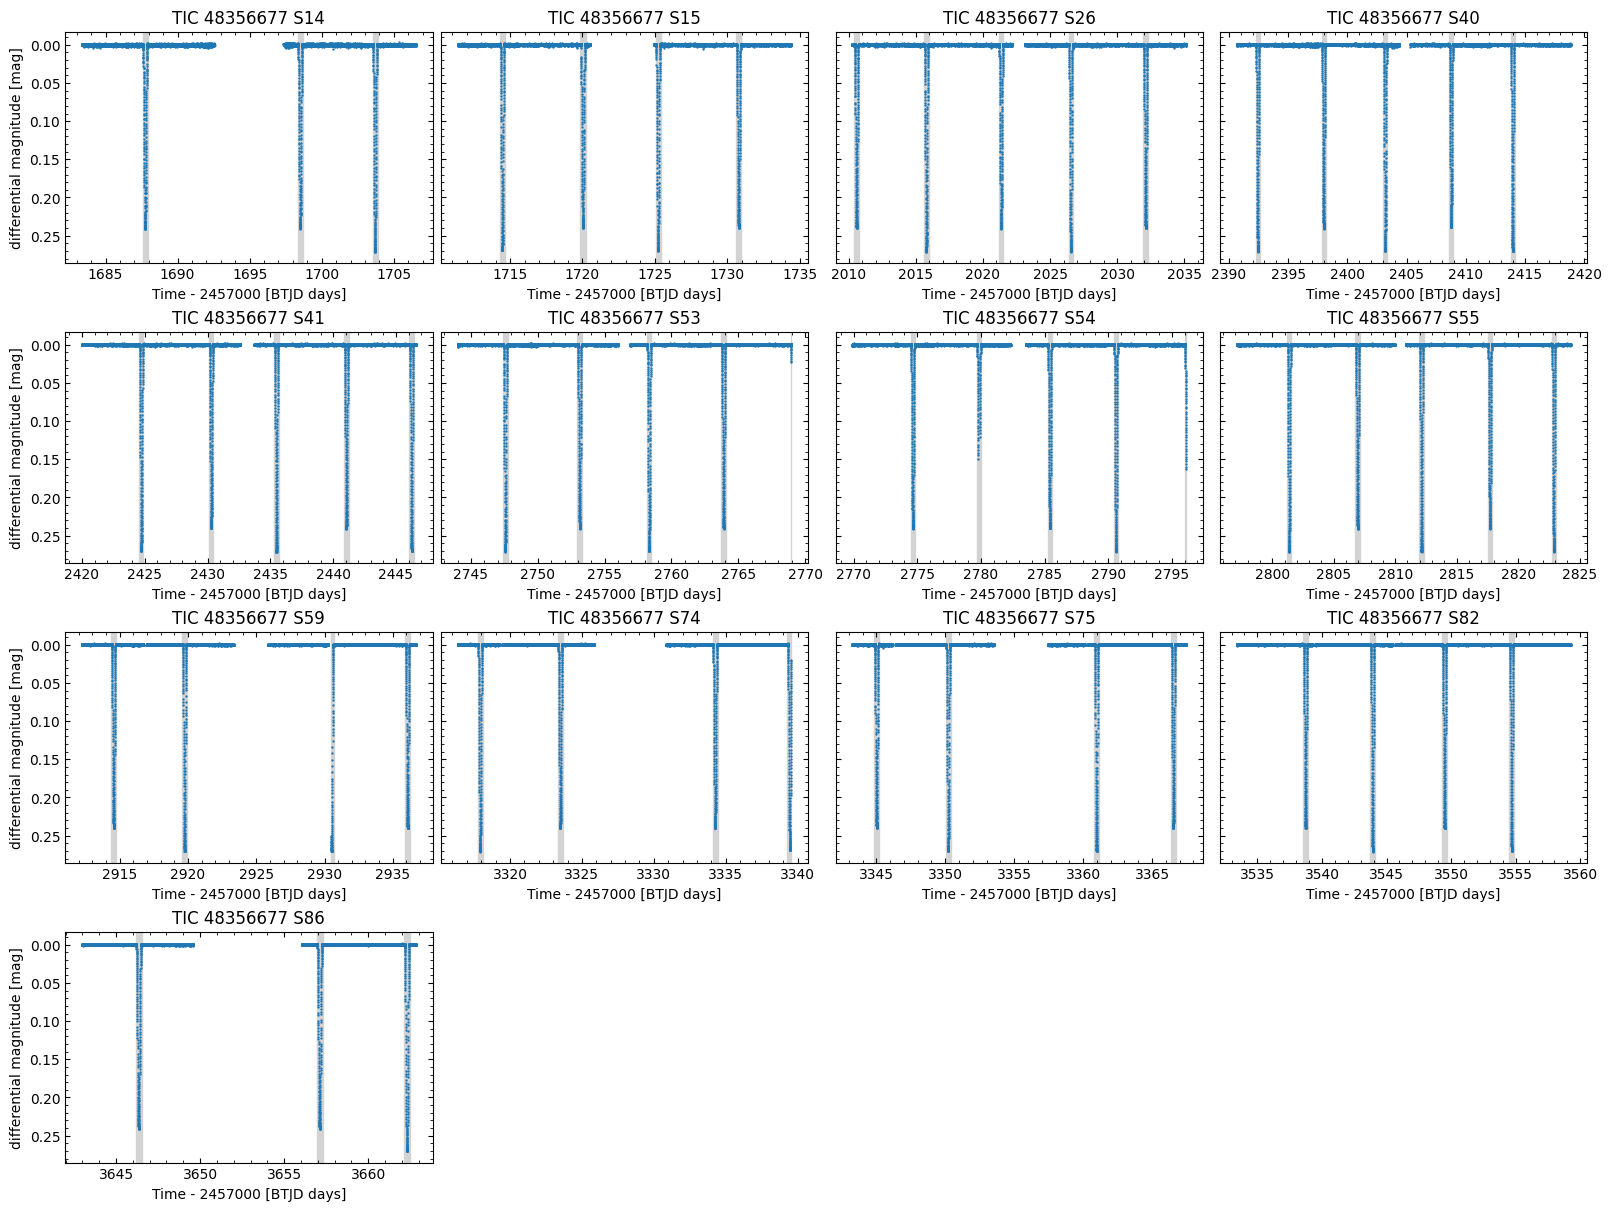

In [14]:
# This will create a new collection of normalized lightcurves,
# stitched as instructed and with metadata updated/concatenated where appropriate.
_sector_groups = literal_eval(sector_groups_text.value) if len(sector_groups_text.value.strip()) else [[s] for s in lcs.sector]
lcs = pipeline.stitch_lightcurve_groups(lcs, _sector_groups, verbose=True)

do_flatten = (target_config.flatten == True) or (target_config.flatten is None and target_meta["morph"] <= FLATTEN_TH)
pipeline.append_mags_to_lightcurves_and_detrend(lcs,
                                                detrend_gap_th=seg_gap_th.value,
                                                detrend_poly_degree=poly_degr.value,
                                                detrend_iterations=dtrd_iters.value,
                                                flatten=do_flatten,
                                                durp=nominal_value(target_meta["durP"]),
                                                durs=nominal_value(target_meta["durS"]),
                                                verbose=True)

def highlight_mask(ix, ax, lc):
    if (_mask := lc.meta.get("flat_mask", None)) is not None:
        for sl in np.ma.clump_masked(np.ma.masked_where(_mask, lc.time.value)):
            ax.axvspan(lc.time[sl.start].value, lc.time[sl.stop-1].value,
                       color="lightgray", zorder=-50, transform=ax.get_xaxis_transform())

plt.show(plots.plot_lightcurves(lcs, "delta_mag", cols=plot_lcs_cols, ax_func=highlight_mask))

### Using EBOP MAVEN to find the fitting input parameters
Now make binned copies of phase folded & phase normalized light curves for each sector group.
The phase of the secondary eclipse (`phiS`) value from the TESS-ebs ephemeris is used to centre
each of the folded light curves on the mid-point between the primary and secondary eclipse. A
binned copy of each light curve is taken for use as the input feature for the
[EBOP MAVEN](https://github.com/SteveOv/ebop_maven) predictions. 

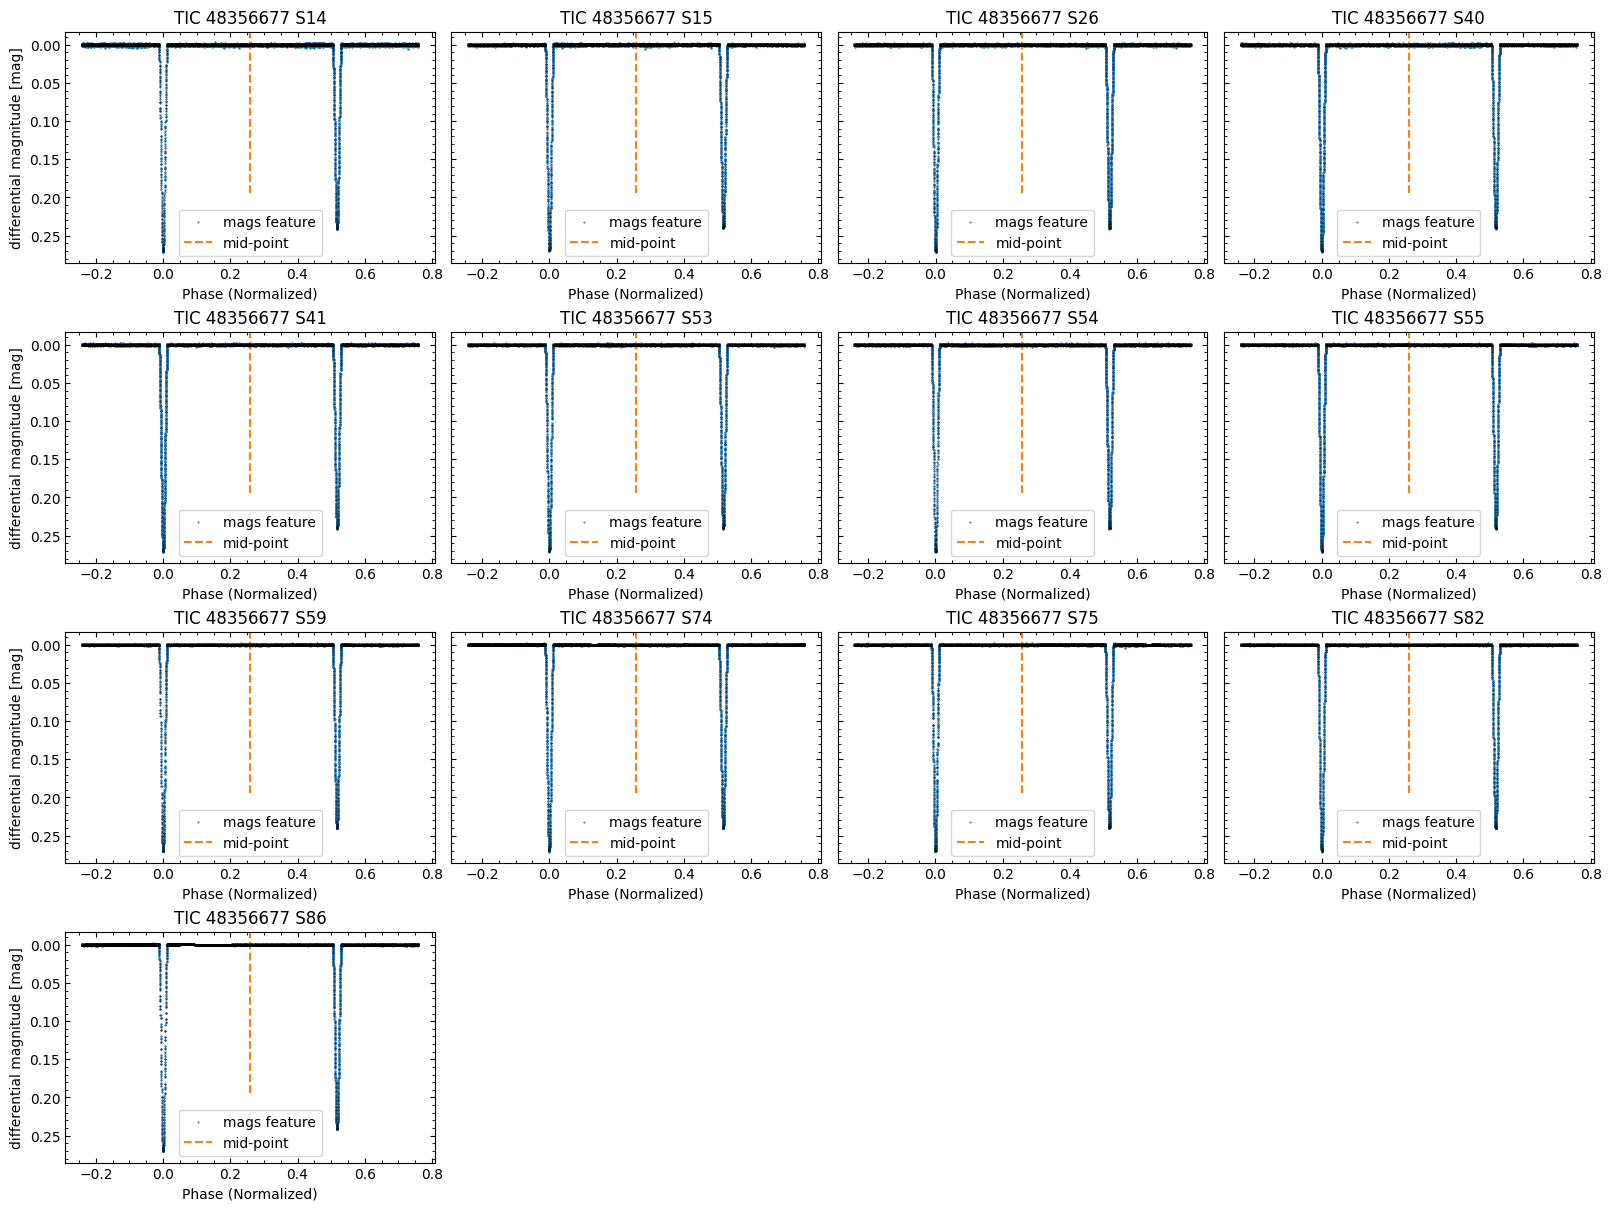

In [15]:
mags_bins = estimator.mags_feature_bins
wrap_phase = u.Quantity(estimator.mags_feature_wrap_phase or (0.5 + nominal_value(target_meta["phiS"]) / 2))
binned_fold = np.zeros(shape=(len(lcs), 2, mags_bins), dtype=np.float32)

_flcs, _period = [], nominal_value(target_meta["period"]) * u.d
for ix, lc in enumerate(lcs):
    _flcs.append(flc := lc.fold(_period, lc.meta["t0"], wrap_phase=wrap_phase, normalize_phase=True))
    binned_fold[ix] = lightcurves.get_binned_phase_mags_data(flc, mags_bins, wrap_phase)

def _plot_feature_and_mid(ix, ax, lc):
    ax.scatter(binned_fold[ix, 0], binned_fold[ix, 1], s=0.33, c="k", marker=".", label="mags feature")
    ax.vlines(0.5, 0.3, 1, "tab:orange", "--", lw=1.5, transform=ax.transAxes, zorder=-10, label="mid-point")

plt.show(plots.plot_lightcurves(_flcs, "delta_mag", cols=plot_lcs_cols, ax_func=_plot_feature_and_mid, legend_loc="best"))

The EBOP MAVEN model predicts values for $r_{\rm A}+r_{\rm B}$, $k$, $J$, $e\cos{\omega}$,
$e\sin{\omega}$ and $b_{\rm P}$ (the primary impact parameter) for each group of sectors.
A single set of predicted values is calculated from the mean values across the groups.

`JKTEBOP` requires an input value for the orbital inclination ($inc$), and this is calculated from
the 6 predicted values.

Mean predicted fitting parameters for HP Dra from 13 sector|group(s), including the value calculated for inc.
    rA_plus_rB:     0.098114+/-    0.004037
             k:     1.069147+/-    0.016738
             J:     0.989750+/-    0.011188
         ecosw:     0.017238+/-    0.002003
         esinw:     0.033052+/-    0.004551
            bP:     0.953393+/-    0.011237
           inc:    87.319478+/-    0.117522 



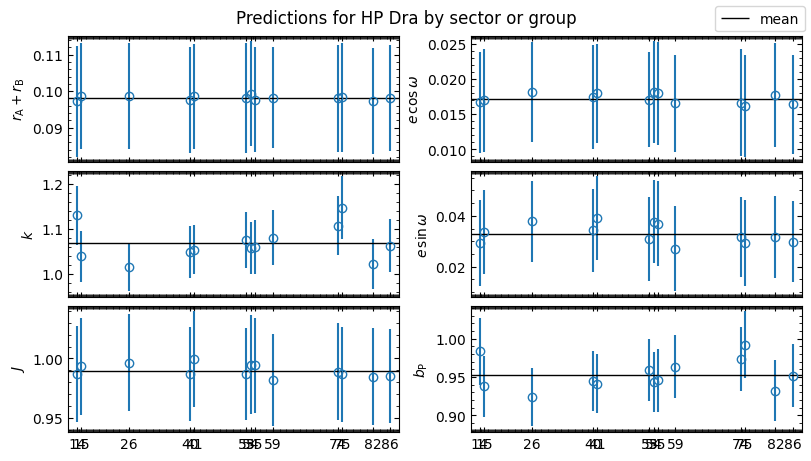

In [16]:
# Predictions for each sector group then aggregate & transform to a dict for JKTEBOP fitting
_preds = estimator.predict(binned_fold[:, 1], iterations=1000)
predictions_dict = pipeline.predictions_to_mean_dict(_preds, calculate_inc=True, inc_key="inc")
print(("Mean predicted" if _preds.size > 1 else "Predicted"), f"fitting parameters for {target}",
      f"from {len(lcs)} sector|group(s), including the value calculated for inc.")
print("\n".join(f"{p:>14s}: {predictions_dict[p]:12.6f}" for p in predictions_dict), "\n")

if _preds.size > 1: # Plot showing the scatter in the predictions
    xmin, xmax = min(lcs.sector) - 2, max(lcs.sector) + 2
    def mean_line(key, ax):
        ax.hlines(nominal_value(predictions_dict[key]), xmin, xmax, "k", "-", lw=1.0, label="mean")

    plt.show(plots.plot_parameter_scatter(_preds, lcs.sector, ax_func=mean_line,
                                          legend_loc="upper right",  xlim=(xmin, xmax),
                                          keys=["rA_plus_rB", "ecosw", "k", "esinw", "J", "bP"],
                                          suptitle=f"Predictions for {target} by sector or group"))

### Estimate the initial third light ($L_{\rm 3}$) parameter
Look for potential sources of third light in the region around the target.
Initialise the fitting of $L_3$ based on the findings.

In [17]:
if "Gaia DR3" in target_ids["type"]:
    _dr3_id = int(target_ids[target_ids["type"]=="Gaia DR3"]["id"][0])
    l3 = pipeline.estimate_l3_with_gaia(target_meta["coords"], 120, target_source_id=_dr3_id, max_l3=0.1, verbose=True)
else:
    _g_mag = lcs[0].meta["TESSMAG"] # Estimate apparent g_mag of target
    l3 = pipeline.estimate_l3_with_gaia(target_meta["coords"], 120, target_g_mag=_g_mag, max_l3=0.1, verbose=True)

display(VBox(children=[
    (l3_check := Checkbox(description="Fit for L3 (if unchecked fix at L3=0)",
                          value=True, style={"description_width": "max-content"})),
]))

_aview = Aladin(fov=0.5, reticle_size=64)
if target_meta.get("coords", None) is not None:
    _aview.target = target_meta["coords"]
_aview # Doesn't display if within an if or try block!

Target object has a Gaia magnitude of 7.8257 (4 d.p.)
Estimated the total third-light ratio (L3) to be 0.0052 (4 d.p.) for the 49 nearby object(s) found in Gaia DR3.


### Perform JKTEBOP analysis
If we have flattened the lightcurves there will be little useful information held in the data
between the eclipses. We have the option to create a mask which will be applied to exclude
these data between eclipses from the JKTEBOP analysis. This can have a marked effect on the time
taken to perform the analysis. The mask is set if;
- the "create_clip_mask" config is set to True
- we've flattened the lightcurves and "create_clip_mask" is unset

In [18]:
_e_width = 5
_durp, _durs = nominal_value(target_meta["durP"]), nominal_value(target_meta["durS"])
for lc in lcs:
    if (target_config.create_clip_mask == True) or (target_config.create_clip_mask is None and do_flatten):
        _mask = lc.meta["clip_mask"] = lightcurves.create_eclipse_mask(lc,
                                                                       lc.meta["primary_times"],
                                                                       lc.meta["secondary_times"],
                                                                       _durp * _e_width,
                                                                       _durs * _e_width)

        print(f"Created clip mask for {lc.meta['LABEL']}. Retaining the {sum(_mask)} of {len(lc)}",
              f"observations within {_e_width/2} eclipse widths of an eclipse for anlysis.")
    else:
        lc.meta["clip_mask"] = np.ones((len(lc)), dtype=bool)

Created clip mask for TIC 48356677 S14. Retaining the 3698 of 13043 observations within 2.5 eclipse widths of an eclipse for anlysis.
Created clip mask for TIC 48356677 S15. Retaining the 3912 of 13226 observations within 2.5 eclipse widths of an eclipse for anlysis.
Created clip mask for TIC 48356677 S26. Retaining the 5307 of 16922 observations within 2.5 eclipse widths of an eclipse for anlysis.
Created clip mask for TIC 48356677 S40. Retaining the 5710 of 19604 observations within 2.5 eclipse widths of an eclipse for anlysis.
Created clip mask for TIC 48356677 S41. Retaining the 5403 of 18321 observations within 2.5 eclipse widths of an eclipse for anlysis.
Created clip mask for TIC 48356677 S53. Retaining the 5065 of 17285 observations within 2.5 eclipse widths of an eclipse for anlysis.
Created clip mask for TIC 48356677 S54. Retaining the 5043 of 17801 observations within 2.5 eclipse widths of an eclipse for anlysis.
Created clip mask for TIC 48356677 S55. Retaining the 5717 of 

In [19]:
task = 3
_mc_sims = 10 # only applies to task 8

# Extract any fitting overrides from the target config. May contain LD params which are handled next
_fit_overrides = copy.deepcopy(target_config.get("jktebop_overrides", {}))

# Generate initial LD params based on the system temperature & log(g) (deferring to any overrides)
_teff_sys = target_meta["Teff_sys"] = target_meta["Teff_sys"] or lcs[0].meta.get("TEFF", None) or 5650
_logg_sys = target_meta["logg_sys"] = target_meta["logg_sys"] or lcs[0].meta.get("LOGG", None) or 4.0
_teffr = predictions_dict["J"]**0.25 # With J*k^2 as a proxy for LR giving teff_rat ~= ((J*k^2)/k^2)^1/4
_ld_params = pipeline.pop_and_complete_ld_config(_fit_overrides,
    *nominal_values((_teff_sys, _teff_sys*_teffr) if _teffr.n < 1 else (_teff_sys/_teffr, _teff_sys)),
    *nominal_values((_logg_sys, _logg_sys)), "pow2", True)

# Specific fit flags which may in future be modified by evaluation of target criteria. Most can be
# 0 (fixed), 1 (fitted), 2 (fixed, but perturbed in MC analysis) # or 3 (freely fitted, but fixed
# for MC analysis). The refl flags can be 0 (fixed), 1 (fitted) or -1 (calculated from sys geometry)
_qphot_fit = 0
_refl_fit = -1 if (target_meta["morph"] <= FLATTEN_TH) else 1
_grav_fit = 0
_l3_fit = int(l3_check.value)
_ecc_fit = 1

if _ecc_fit == 0:
    _fit_overrides["ecosw"] = 0
    _fit_overrides["esinw"] = 0

_in_params = {
    # Mass ratio (qphot), can be -1 (force spherical) or a specified ratio value
    "qphot": -1 if (target_meta["morph"] <= FLATTEN_TH) else predictions_dict["k"]**1.4,
    "gravA": 0.,                "gravB": 0.,
    "L3": l3 if _l3_fit else 0,
    "reflA": 0.,                "reflB": 0.,

    "period": nominal_value(target_meta["period"]),

    "qphot_fit": _qphot_fit,
    "ecosw_fit": _ecc_fit,       "esinw_fit": _ecc_fit,
    "gravA_fit": _grav_fit,      "gravB_fit": _grav_fit,
    "L3_fit": _l3_fit,
    "LDA1_fit": 1,              "LDB1_fit": 1,
    "LDA2_fit": 0,              "LDB2_fit": 0,
    "reflA_fit": _refl_fit,      "reflB_fit": _refl_fit,
    "sf_fit": 1,
    "period_fit": 1,            "primary_epoch_fit": 1,

    **predictions_dict,
    **_ld_params,
    **_fit_overrides,
}

# Superset of all of the potentially fitted parameters to be read from fitting
_fitted_param_keys = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "period", "ecc", "bP", "rA", "rB", "light_ratio", "qphot", "reflA", "reflB"]

# If max_workers >1 progress updates will occur after each attempt is complete, but overall elapsed
# time is reduced. If set to 1, tasks are serialized but more frequent progress updates will occur.
_max_workers = 8 if task == 3 else 1
_pe = [nominal_value(lc.meta.get("t0", target_meta["t0"])) for lc in lcs]
_fitted_param_dicts = pipeline.fit_target_lightcurves(lcs, _in_params, _fitted_param_keys, _pe,
                                                      task, _mc_sims, _max_workers, max_attempts=3,
                                                      timeout=900, file_prefix="quick-fit")

# Get the results into a structured array format
fitted_params = np.empty(shape=(len(lcs), ), dtype=[(k, np.dtype(UFloat.dtype)) for k in _fitted_param_keys])
for ix, lc in enumerate(lcs):
    lc.meta["out_fname"] = _fitted_param_dicts[ix]["out_fname"]
    lc.meta["fit_fname"] = _fitted_param_dicts[ix]["fit_fname"]
    for k in _fitted_param_keys:
        fitted_params[ix][k] = _fitted_param_dicts[ix][k]

Limb darkening params: StarA=pow2(0.62126849, 0.65346716), StarB=pow2(0.62126849, 0.65346716)
  
JKTEBOP++ 44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  quick-fit-tic-48356677-s54.a1.par                 
>> Opened new LC output  file:  quick-fit-tic-48356677-s54.a1.out                 
>> Opened new model fit  file:  quick-fit-tic-48356677-s54.a1.fit                 
>> Read   5043 datapoints (with errors) from file quick-fit-tic-48356677-s54.dat                    
>> Read  1 polynomial datasets from the input file
>> Best fit has been found after 42 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:   2.550 
>> Done iteration 2 to adjust errorbars. Chisqred values:   0.993 
>> Done iteration 3 to adjust errorbars. Chisqred values:   1

#### Report of JKTEBOP fitting results

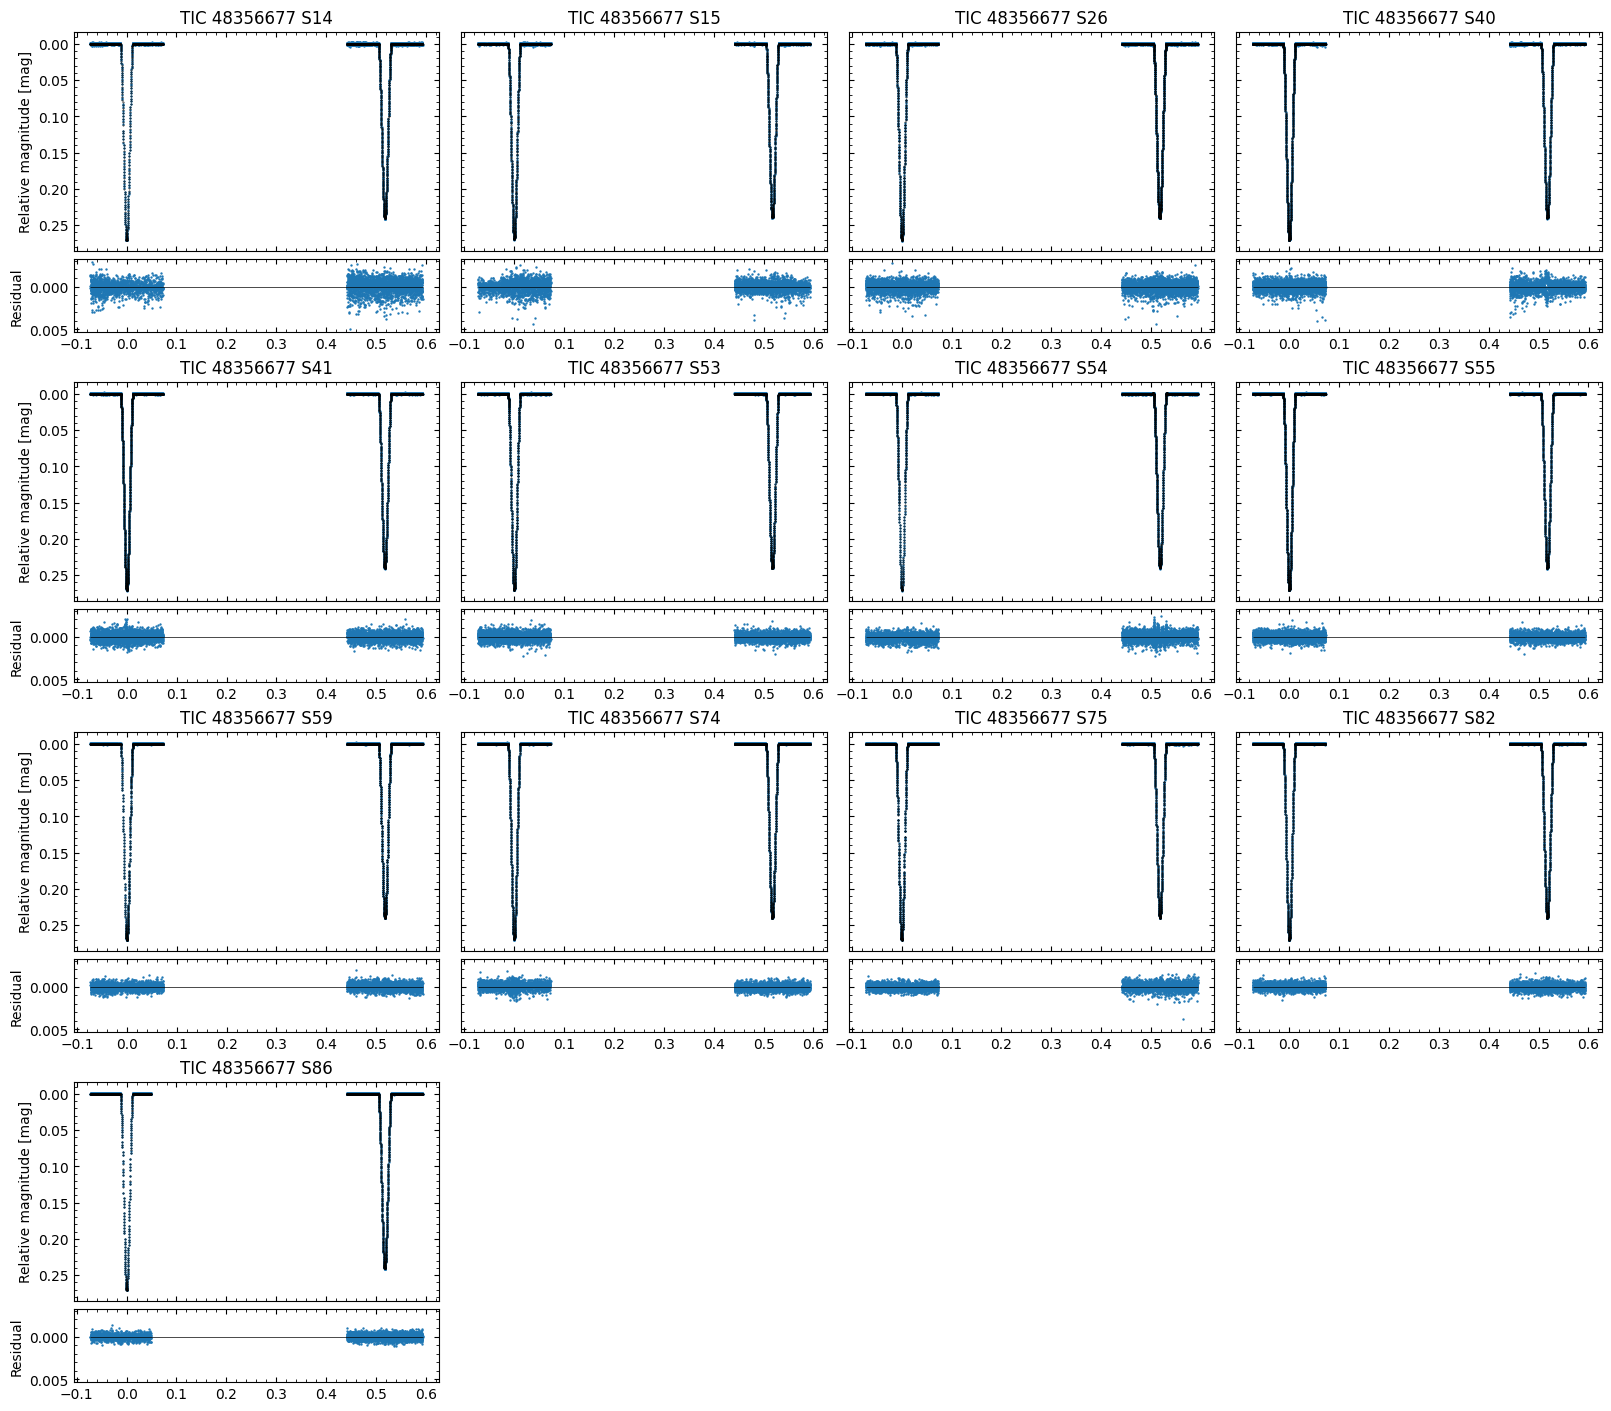

In [20]:
if task == 3:
    cols = plot_lcs_cols
    rows = int(np.ceil(len(lcs) / cols))
    fig, axes = plt.subplots(rows*2, cols, figsize=(4*cols, 3.5*rows), height_ratios=(3, 1)*rows, constrained_layout=True)

    for ix in range(axes.size//2):
        row, col = int(np.floor(ix / cols) * 2), ix % cols
        if len(axes.shape) == 1: # If cols == 1 then we may not get axes with the second dimension
            ax_lc, ax_res = axes[row], axes[row+1]
        else:
            ax_lc, ax_res = axes[row, col], axes[row+1, col]
        
        if ix < len(lcs):
            # Pick columns so they are ordered [phase, lc_mag, model_mag, residual]
            out_data = np.loadtxt(lcs[ix].meta["out_fname"], float, comments="#", usecols=[3, 1, 4, 5], unpack=True)
            out_data[0][out_data[0] > wrap_phase.value] -= 1. # matches wrap used previously
        
            if ix < len(lcs):
                ax_lc.scatter(out_data[0], out_data[1], s=2.0, marker=".", label=None)
                ax_lc.scatter(out_data[0], out_data[2], s=0.5, c="k", marker=".", label=None)
                ax_res.scatter(out_data[0], out_data[3], s=2.0, marker=".", label=None)
                ax_res.hlines([0.0], min(out_data[0]), max(out_data[0]), ls="-", color="k", lw=.5)

                if ix == 0:
                    ax_lc.invert_yaxis()
                    ax_res.invert_yaxis()
                else:
                    ax_lc.sharey(axes[0, 0])
                    ax_res.sharey(axes[1, 0])
        
                # Hides tick labels on inner facing shared axes
                plt.setp(ax_lc.get_xticklabels(), visible=False) 
                if col > 0:
                    plt.setp(ax_lc.get_yticklabels(), visible=False)
                    plt.setp(ax_res.get_yticklabels(), visible=False)
                plots.format_axes(ax_lc, title=lcs[ix].meta["LABEL"], ylabel="" if ix % cols else "Relative magnitude [mag]")
                plots.format_axes(ax_res, ylabel="" if ix % cols else "Residual")
        else:
            ax_lc.axis("off")
            ax_res.axis("off")
    plt.show(fig)

Aggregate the fitting results from each sector into a single set of fitted parameters.
The errorbars from fitting with task 3 are formal and will significantly under report.
We can use the median values across the sectors with the uncertainty derived from the
standard deviation in the scatter of the values.

Median parameter values and 2-sigma uncertainties for HP Dra from 13 fitted sector groups.
    rA_plus_rB:     0.089387+/-    0.000338
             k:     0.925835+/-    0.063164
             J:     0.963436+/-    0.022714
         ecosw:     0.027359+/-    0.000039
         esinw:     0.024628+/-    0.002223
           inc:    87.552676+/-    0.033876
            L3:     0.002636+/-    0.011011
        period:    10.761536+/-    0.000076
           ecc:     0.036810+/-    0.001444
            bP:     0.904490+/-    0.035523
            rA:     0.046665+/-    0.001463
            rB:     0.043041+/-    0.001531
   light_ratio:     0.816460+/-    0.110511
         qphot:    -1.000000+/-           0
         reflA:     0.000389+/-    0.000006
         reflB:     0.000406+/-    0.000006 

    Teff_ratio:     0.987909+/-    0.047468 (calculated from light_ratio & k)


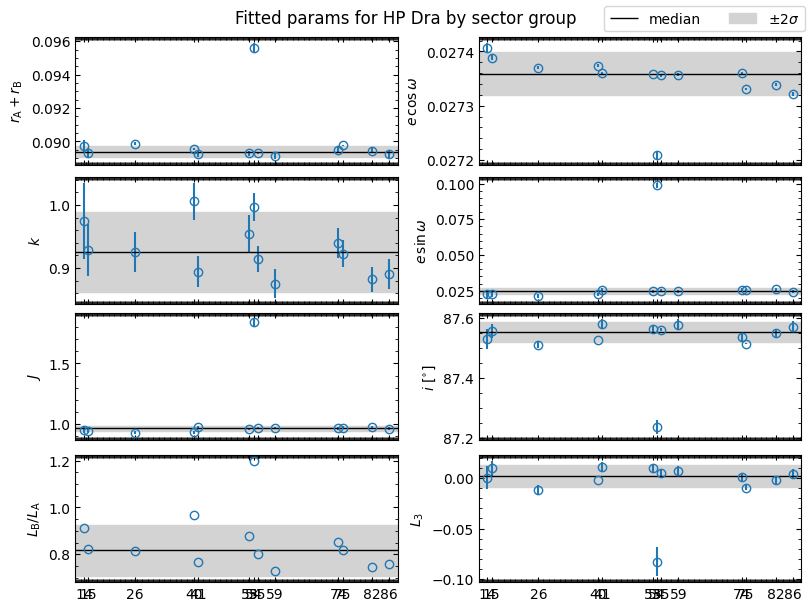

In [21]:
# If there's only 1 sector/group we use the predictions directly, otherwise we use the median and
# 2-sigma (the sample is relatively small) over the scatter of the predictions for the uncertainty.
if fitted_params.size > 1:
    summary_params = pipeline.median_params(fitted_params, quant_size=0.9545, exclude_outliers=True)
    print(f"Median parameter values and 2-sigma uncertainties for {target} from {len(lcs)} fitted sector groups.")
else:
    summary_params = fitted_params[0]
    print(f"Parameter values and formal error bars for {target} over 1 fitted sector group.")
print("\n".join(f"{p:>14s}: {summary_params[p]:12.6f}" for p in summary_params.dtype.names if summary_params[p] is not None), "\n")

target_meta["Teff_ratio"] = (summary_params["light_ratio"] / summary_params["k"]**2)**0.25
target_meta["radius_ratio"] = summary_params["k"]
print(f"    Teff_ratio: {target_meta['Teff_ratio']:12.6f} (calculated from light_ratio & k)")

if fitted_params.size > 1: # Plot showing the scatter in key fitted params
    xmin, xmax = lcs.sector.min() - 2, lcs.sector.max() + 2
    def median_and_sigma_region(key, ax):
        sval = summary_params[key]
        ax.hlines([sval.n], xmin, xmax, "k", "-", lw=1.0, label="median")        
        ax.axhspan(sval.n-sval.s, sval.n+sval.s, color="lightgray", zorder=-50, label=r"$\pm2\sigma$")

    plt.show(plots.plot_parameter_scatter(fitted_params, lcs.sector, ax_func=median_and_sigma_region,
                                          keys=["rA_plus_rB", "ecosw", "k", "esinw", "J", "inc", "light_ratio", "L3"],
                                          suptitle=f"Fitted params for {target} by sector group",
                                          xlim=(xmin, xmax), legend_loc="upper right", legend_ncol=2))

In [22]:
print(f"Querying the JustesenAlbrecht21apj catalogue of southern hemisphere TESS EBs (J/ApJ/912/123 T3).")
if (_tebs_sh_data := query_tess_ebs_in_sh(target_meta["tics"])):
    print("\n".join(f"{p:>14s}: {_tebs_sh_data[p]:12.6f}" for p in _tebs_sh_data if _tebs_sh_data[p] is not None), "\n")
else:
    print("Not found in catalogue.")

Querying the JustesenAlbrecht21apj catalogue of southern hemisphere TESS EBs (J/ApJ/912/123 T3).
Not found in catalogue.


### Load our support data for MCMC fitting the target's SED

In [23]:
# Extinction model: G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model which covers the range from",
      f"{min(ext_wl_range):unicode} to {max(ext_wl_range):unicode}.")

Using the G23 extinction model which covers the range from 0.0912 µm to 32.0 µm.


This loads a grid of fluxes, in this case derived from bt-settl-agss or Kurucz ODFNEW /NOVER models.
The StellarGrid classes are used by the SED fitting code to generate model SEDs for fitting.

In [24]:
# Model SED grid based on atmosphere models with known filters pre-applied to non-reddened fluxes
# Available grids: BtSettlGrid or KuruczGrid
model_grid = get_stellar_grid("BtSettlGrid", extinction_model=ext_model, verbose=True) 

print(f"Loaded grid based on synthetic models, covering the ranges:")
print(f"wavelength {model_grid.wavelength_range * model_grid.wavelength_unit:unicode},",
      f"Teff {model_grid.teff_range * model_grid.teff_unit:unicode},",
      f"logg {model_grid.logg_range * model_grid.logg_unit:unicode}",
      f"\nand metallicity {model_grid.metal_range * u.dimensionless_unscaled:unicode},",
      f"with fluxes returned in units of {model_grid.flux_unit:unicode}")

Loading model grid from bt-settl-agss.npz created at 2025-11-19 18:41:01.266422+00:00
BtSettlGrid is initializing the fluxes interpolator with the grid of 112 teff, 6 logg & 4 metal values and 5000 wavelength bins...will use slinear interpolation...done.
Initializing unreddened fluxes for 39 filters.......................................done.
Loaded grid based on synthetic models, covering the ranges:
wavelength [ 0.09120575 31.99861909] µm, Teff [ 2000. 40000.] K, logg [3.  5.5] dex 
and metallicity [-0.5  0.5], with fluxes returned in units of W m⁻²


### Locate and prepare the target's spectral energy distribution (SED) data
Query for the target's SED with the Vizier SED service which aggregates
flux measurements from various systematic sky surveys. Once we have this
we need to deredden the SED prior to fitting for stellar masses

In [25]:
# Read in the SED for this target and de-duplicate (measurements may appear multiple times).
# Plots are unit agnostic and plot wl [um] and vF(v) [W/m^2] on x and y.
sed = get_sed_for_target(target, target_meta["search_term"], radius=0.1, remove_duplicates=True, verbose=True)

sed = group_and_average_fluxes(sed, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
model_mask = np.ones((len(sed)), dtype=bool)
model_mask &= model_grid.has_filter(sed["sed_filter"])
model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) \
            & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_grid.wavelength_range)) \
            & (sed["sed_wl"] <= max(model_grid.wavelength_range))
sed = sed[model_mask]

out_mask = create_outliers_mask(sed, nominal_value(target_meta["Teff_sys"]), [target_meta["Teff_ratio"]], min_unmasked=15, verbose=True)
sed = sed[~out_mask]

sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after range and outlier filtering",
      "\nwith the units for flux, frequency and wavelength being",
      ", ".join(f"{sed[f].unit:unicode}" for f in ["sed_flux", "sed_freq", "sed_wl"]))

Opened SED table hp-dra-0.1.vot containing 125 row(s).
Dropped 63 duplicate(s) leaving 62 unique row(s).
Grouped SED by ['sed_filter', 'sed_freq'] yielding 26 group(s) from 62 row(s).
Calculating the group means of the [('sed_flux', 'sed_eflux')] columns
Will find outliers by based on quick BB fits with initial Teff(s) = [6110.000, 6036.125] & Teff ratio priors = [0.988]+/-5%
[000] stat = 2.354e+01
[001] stat = 1.835e+01; 1/20 outliers masked for Johnson:H
[002] stat = 1.303e+01; 2/20 outliers masked for Johnson:H, Johnson:J
[003] stat = 5.796e+00; no significant improvement so stopped further masking
18 unique SED observation(s) retained after range and outlier filtering 
with the units for flux, frequency and wavelength being W Hz⁻¹ m⁻², Hz, µm


Deredden the SED fluxes. This greatly speeds up the SED fitting as it removes the requirement to
fit for extinction, which requires model fluxes to be redenned for every fitting iteration.

In [26]:
av = target_config.get("av", None)
if not av:
    # Get the mean of the various catalogues, prioritising converged results
    _ext_funcs = ["get_gontcharov_ebv", "get_bayestar_ebv"]
    for conv in [True, False]:
        avs = [v for v, flags in extinction.get_av(target_meta["coords"], _ext_funcs, ext_model.Rv, True)
                    if flags.get("converged", False) == conv]
        if len(avs):
            av = np.mean(avs)
            print(f"Found mean extinction of {len(avs)} catalogue(s): A_V = {av:.6f}")
            break

if av:
    print(f"Dereddening observations with A_V={av:.3f}")
    sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Av=av)
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

get_gontcharov_ebv=0.075 [converged=True]
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.327 s
  pix_info:   0.359 s
   samples:  14.031 s
      best:   2.797 s
       nan:   0.023 s
      sort:   8.043 s
       idx:   0.075 s
get_bayestar_ebv=0.000 [converged=True]
Found mean extinction of 2 catalogue(s): A_V = 0.116165
Dereddening observations with A_V=0.116


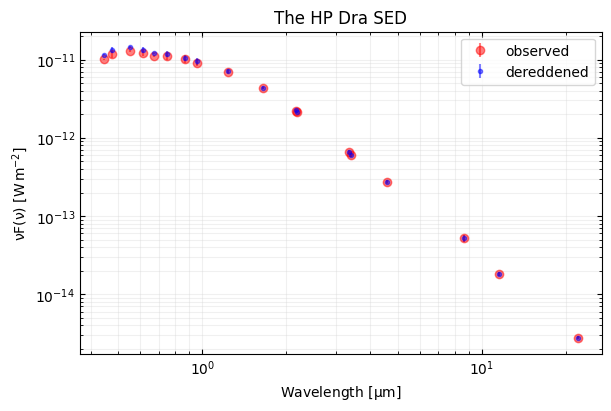

In [27]:
plt.show(plots.plot_sed(sed["sed_wl"].quantity,
                        fluxes=[sed["sed_flux"].quantity, sed["sed_der_flux"].quantity],
                        flux_errs=[sed["sed_eflux"].quantity]*2,
                        fmts=["or", ".b"],
                        labels=["observed", der_lab],
                        title=f"The {target} SED"))

### Set up the functions which will support SED fitting

Setting the starting position for the fit, `theta0`, which is our best estimate of the fitted
values for the system based on existing published data and any light curve fitting carried
out previously.

The `fit_mask` indicates which of the values in `theta0` is fitted (`True`) with the remainder
being fixed (`False`).

**Note:** currently we're not fitting for $\log{g}$, instead using fixed values for each star.

In [28]:
NUM_STARS = 2

subs = "ABCDEFGHIJKLM"
theta_plot_labels = np.array([f"$T_{{\\rm eff,{subs[st]}}} / {{\\rm K}}$" for st in range(NUM_STARS)] \
                            +[f"$\\log{{g}}_{{\\rm {subs[st]}}}$" for st in range(NUM_STARS)] \
                            +[f"$R_{{\\rm {subs[st]}}} / {{\\rm R_{{\\odot}}}}$" for st in range(NUM_STARS)] \
                            +["${\\rm D} / {\\rm pc}$", "${\\rm A_{V}}$"])

theta_labels = np.array([(f"Teff{subs[st]}", u.K) for st in range(NUM_STARS)] \
                        +[(f"logg{subs[st]}", u.dex) for st in range(NUM_STARS)] \
                        +[(f"R{subs[st]}", u.Rsun) for st in range(NUM_STARS)] \
                        +[("D", u.pc), ("av", u.dimensionless_unscaled)])

In [29]:
theta0 = create_theta(teffs=nominal_value(target_meta["Teff_sys"]),
                      loggs=nominal_value(target_meta["logg_sys"]),
                      radii=1.0,
                      dist=target_meta["coords"].distance.to(u.pc).value,
                      av=0,
                      nstars=NUM_STARS,
                      verbose=True)

fit_mask = np.array([True] * NUM_STARS      # teff
                  + [False] * NUM_STARS     # logg
                  + [True] * NUM_STARS      # radius
                  + [True]                  # dist
                  + [False])                # av (we've handled av by derredening the SED)

theta:	 6.110e+03, 6.110e+03, 4.052e+00, 4.052e+00, 1.000e+00, 1.000e+00, 7.927e+01, 0.000e+00


Set up priors' limit and ratio criteria for the fitting. These use the effective temperature and
radius ratios calculated previously from light curve fitting results. Additionally, limits are
applied based on the available SED model's temperature range and a sensible range of stellar radii.

The fit's candidate parameters will be evaluated against the priors by the `ln_prior_func`
function below, which the fitting code will invoke at the start of each iteration.

In [30]:
teff_limits = model_grid.teff_range
radius_limits = (0.1, 100)

# For now, hard coded to 2 stars. Ratios wrt the primary components - we ignore the 0th item.
_teff_ratio, _radius_ratio = target_meta["Teff_ratio"], target_meta["radius_ratio"]
teff_ratios = [ufloat(_teff_ratio.n, max(_teff_ratio.s, _teff_ratio.n * 0.1))] * NUM_STARS
radius_ratios = [ufloat(_radius_ratio.n, max(_radius_ratio.s, _radius_ratio.n * 0.1))] * NUM_STARS

dist_prior = ufloat(target_meta["coords"].distance.value, target_meta["coords"].distance.value * 0.05)

def ln_prior_func(theta: np.ndarray[float]) -> float:
    """
    The fitting prior callback function to evaluate the current set of candidate
    parameters (theta), returning a single ln(value) indicating their "goodness".
    """
    teffs = theta[0:NUM_STARS]
    radii = theta[NUM_STARS*2:NUM_STARS*3]
    dist = theta[-2]

    # Limit criteria checks - hard pass/fail on these
    if not all(teff_limits[0] <= t <= teff_limits[1] for t in teffs) or \
        not all(radius_limits[0] <= r <= radius_limits[1] for r in radii):
        return np.inf

    # Gaussian prior criteria: g(x) = 1/(σ*sqrt(2*pi)) * exp(-1/2 * (x-µ)^2/σ^2)
    # Omitting scaling expressions for now and note the implicit ln() cancelling the exp
    ret_val = 0
    for star_ix in range(1, NUM_STARS):
        ret_val += ((teffs[star_ix] / teffs[0] - teff_ratios[star_ix].n) / _teff_ratio.s)**2
        ret_val += ((radii[star_ix] / radii[0] - radius_ratios[star_ix].n) / _teff_ratio.s)**2
    ret_val += ((dist - dist_prior.n) / dist_prior.s)**2
    return 0.5 * ret_val

Get the observed SED data into a format for fitting. The flux units need to match
those produced by the model grid.

In [31]:
# Prepare the data to be fitted
x = model_grid.get_filter_indices(sed["sed_filter"])
y = (sed["sed_der_flux"].quantity * sed["sed_freq"].quantity)\
                                    .to(model_grid.flux_unit, equivalencies=u.spectral()).value
y_err = (sed["sed_eflux"].quantity * sed["sed_freq"].quantity)\
                                    .to(model_grid.flux_unit, equivalencies=u.spectral()).value

#### Perform a "quick" minimize SED fit for the stars' effective temperatures, radii and distance

In [32]:
theta_min_fit, _ = minimize_fit(x, y, y_err=y_err, theta0=theta0, fit_mask=fit_mask,
                                ln_prior_func=ln_prior_func, stellar_grid=model_grid, verbose=True)

minimize_fit(theta0=[6.110e+03*, 6.110e+03*, 4.052e+00, 4.052e+00, 1.000e+00*, 1.000e+00*, 7.927e+01*, 0.000e+00])
(Nelder-Mead) succeeded after 318 iterations & 529 function evaluation(s) [fun = 0.741380]
(SLSQP) succeeded after 38 iterations & 235 function evaluation(s) [fun = 0.741380]
(None) succeeded after 50 iterations & 340 function evaluation(s) [fun = 0.741380]
The best fit with Nelder-Mead method yielded theta=[6.108e+03*, 6.027e+03*, 4.052e+00, 4.052e+00, 1.253e+00*, 1.160e+00*, 7.927e+01*, 0.000e+00]


Best fit parameters for HP Dra from minimization fit (* indicates fitted parameter):
       TeffA* = 6108.239 K
       TeffB* = 6026.926 K
       loggA  = 4.052 dex
       loggB  = 4.052 dex
          RA* = 1.253 R☉
          RB* = 1.160 R☉
           D* = 79.269 pc
          av  = 0.000 


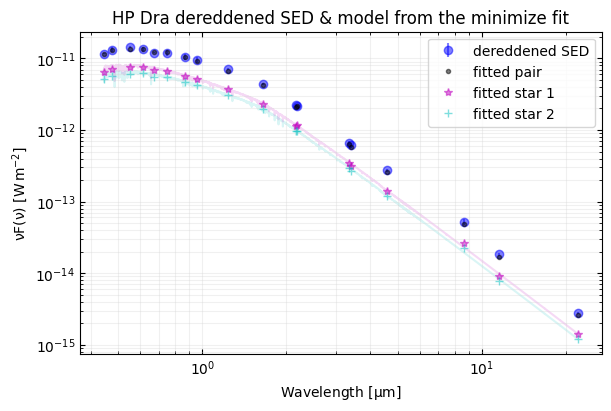

In [33]:
print(f"Best fit parameters for {target} from minimization fit (* indicates fitted parameter):")
for (k, unit), theta_val, mask in zip(theta_labels, theta_min_fit, fit_mask):
    print(f"{k:>12s}{'*' if mask else ' ':s} = {theta_val:.3f} {unit:unicode}")
    # *** Also updates the target_data ***
    target_meta[k] = theta_val

plt.show(plots.plot_fitted_model_sed(sed, theta_min_fit, model_grid,
                                 title=f"{target} dereddened SED & model from the minimize fit"))

#### Perform a MCMC SED fit for more reliable fit with uncertainties from a probability distribution

mcmc_fit(theta0=[6.108e+03*, 6.027e+03*, 4.052e+00, 4.052e+00, 1.253e+00*, 1.160e+00*, 7.927e+01*, 0.000e+00])
Running MCMC fit on 8 process(es) with 100 walkers for 100000 steps, sampling every 10 steps.
Early stopping is enabled after 12500 steps.


 17%|█▋        | 17000/100000 [10:58<53:34, 25.82it/s]  


Halting MCMC after 17000 steps as the walkers are past 100 times the autocorrelation time & the fit has converged.
Mean Acceptance fraction:    0.548
Autocorrelation steps (tau): 56.481, 57.444, 56.621, 55.657, 56.328
Estimated burn-in steps:     120
Leaving samples of shape:    (168800, 5) *flattened
The MCMC fit yielded theta:  [(6.110+/-0.141)e+03*, (6.025+/-0.171)e+03*, (4.052+/-0)e+00, (4.052+/-0)e+00, (1.261+/-0.072)e+00*, (1.163+/-0.069)e+00*, (7.966+/-0.394)e+01*, (0.000+/-0)e+00]


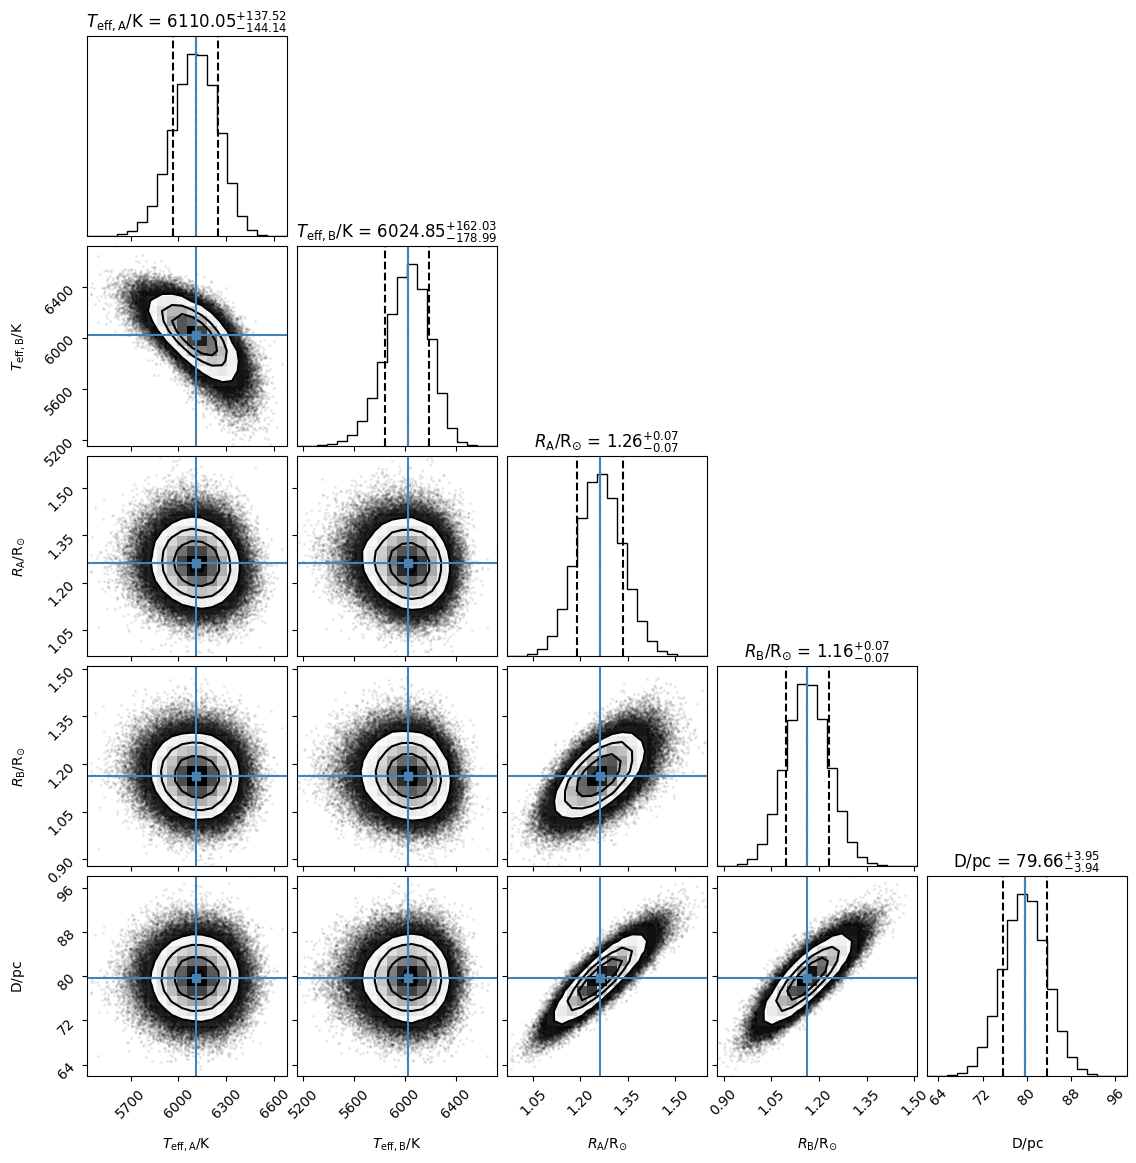

In [34]:
thin_by = 10 # sample every nth step from the chain
theta_mcmc_fit, _sampler = mcmc_fit(x, y, y_err, theta0=theta_min_fit, fit_mask=fit_mask,
                                    ln_prior_func=ln_prior_func, stellar_grid=model_grid, 
                                    nwalkers=100, nsteps=100000, thin_by=thin_by, seed=42,
                                    early_stopping=True, processes=8, progress=True, verbose=True)

plt.show(corner.corner(data=samples_from_sampler(_sampler, thin_by=thin_by, flat=True),
                       show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                       labels=theta_plot_labels[fit_mask], truths=nominal_values(theta_mcmc_fit[fit_mask])))

Final parameters for HP Dra with nominals & 1-sigma uncertainties from MCMC fit ([known value])
       TeffA* = 6110.048+/-140.829 K 	 (6000.000+/-150.000 K)
       TeffB* = 6024.854+/-170.508 K 	 (5935.000+/-150.000 K)
       loggA  = 4.052+/-0 dex 	 (4.301+/-0.003 dex)
       loggB  = 4.052+/-0 dex 	 (4.358+/-0.004 dex)
          RA* = 1.261+/-0.072 R☉ 	 (1.247+/-0.005 R☉)
          RB* = 1.163+/-0.069 R☉ 	 (1.150+/-0.005 R☉)
           D* = 79.657+/-3.941 pc 	 (79.269 pc)
          av  = 0.000+/-0  	 


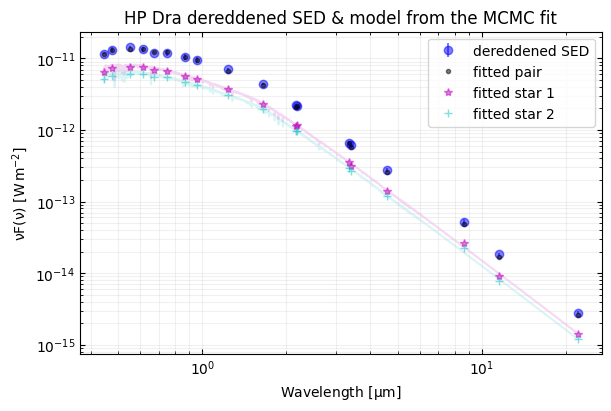

In [35]:
print(f"Final parameters for {target} with nominals & 1-sigma uncertainties from MCMC fit ([known value])")
for (k, unit), theta_val, mask in zip(theta_labels, theta_mcmc_fit, fit_mask):
    known = ""
    if k == "D":
        known = f"({target_meta['coords'].distance.to(u.pc).value:.3f} pc)"
    elif target_config.get("labels", {}).get(k, None) is not None:
        value = ufloat(target_config.labels.get(k, np.NaN), target_config.labels.get(k + "_err", 0))
        known = f"({value:.3f} {unit:unicode})"
    print(f"{k:>12s}{'*' if mask else ' ':s} = {theta_val:.3f} {unit:unicode} \t", known)
    # *** also updates the target data ***
    target_meta[k] = theta_val

plt.show(plots.plot_fitted_model_sed(sed, theta_mcmc_fit, model_grid,
                                 title=f"{target} dereddened SED & model from the MCMC fit"))

### Perform a MCMC fit against MIST isochrones to find the stellar masses and age
Start by calculating the system's semi-major axis ($a$) and system mass ($M_{\rm sys}$) from
the fitted full & fractional radii and the orbital period.

In [36]:
# semi-major axis
target_meta["a"] = np.mean([target_meta["RA"] / summary_params["rA"],
                           target_meta["RB"] / summary_params["rB"]])
print(f"semi-major axis (a):    {target_meta['a']:.3f} {u.Rsun:unicode} (from fitted & fractional radii)")

# total mass of the system
target_meta["mass_sys"] = (4 * np.pi**2 * (target_meta["a"] * R_sun)**3) \
                        / (G * (summary_params["period"] * 86400)**2) / M_sun
print(f"total system mass:      {target_meta['mass_sys']:.3f} {u.Msun:unicode} (from semi-major axis & period)")

semi-major axis (a):    27.030+/-1.280 R☉ (from fitted & fractional radii)
total system mass:      2.288+/-0.325 M☉ (from semi-major axis & period)


Then perform a MCMC fit against MIST isochrones to find the individual component masses and system
age, while using the fitted radii & effective temperatures and the total system mass as priors.

In [37]:
import libs.fit_masses as fit_masses

def print_mass_theta(theta, label: str="theta"):
    print(f"{label} = [" + ", ".join(f"{t:.3e}" for t in theta) + "]\n") 

# Priors: observations from SED fitting
obs_radii = np.array([target_meta["RA"], target_meta["RB"]])
obs_teffs = np.array([target_meta["TeffA"], target_meta["TeffB"]])

# Estimate fit starting position with masses based on the observed radii and a reasonable M-S age
_theta_masses = np.array([target_meta["mass_sys"] * r for r in obs_radii])
_theta_masses *= (target_meta["mass_sys"] / np.sum(_theta_masses))
_theta_age = [9.0 if max(nominal_values(_theta_masses)) <= 2.0 else 8.0]
mass_theta0 = np.concatenate([nominal_values(_theta_masses), _theta_age]) # initial masses and log age
print_mass_theta(mass_theta0, "mass_theta0")

mass_min_theta, _ = fit_masses.minimize_fit(mass_theta0, target_meta["mass_sys"], obs_radii, obs_teffs, verbose=True)
print_mass_theta(mass_min_theta, "mass_min_theta")

Reading in: /home/steveo/projects/main/modebs/libs/data/mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso
mass_theta0 = [1.190e+00, 1.098e+00, 9.000e+00]

(Nelder-Mead) succeeded after 60 iterations & 128 function evaluation(s) [fun = 0.282242]
(SLSQP) succeeded after 2 iterations & 18 function evaluation(s) [fun = 1.616438]
(None) failed [Desired error not necessarily achieved due to precision loss.] after 1 iterations & 144 function evaluation(s) [fun = 1.143411]
Taking the best fit from the Nelder-Mead method
mass_min_theta = [1.168e+00, 1.120e+00, 9.549e+00]



In [38]:
thin_by = 10
mass_mcmc_theta, mass_sampler = fit_masses.mcmc_fit(mass_min_theta, target_meta["mass_sys"],
                                                    obs_radii, obs_teffs, nwalkers=100,
                                                    nsteps=100000, thin_by=thin_by, seed=42,
                                                    early_stopping=True, early_stopping_threshold=0.01,
                                                    processes=8, progress=True, verbose=True)
print_mass_theta(mass_mcmc_theta, "mass_mcmc_theta")

 23%|██▎       | 23000/100000 [03:35<12:00, 106.86it/s]


Halting MCMC after 23000 steps as the walkers are past 100 times the autocorrelation time & the fit has converged.
Mean Acceptance fraction:    0.389
Autocorrelation steps (tau): 133.774, 134.338, 219.939
Estimated burn-in steps:     440
Leaving samples of shape:    (225600, 3) *flattened
mass_mcmc_theta = [(1.159+/-0.120)e+00, (1.117+/-0.130)e+00, (7.954+/-0.984)e+00]



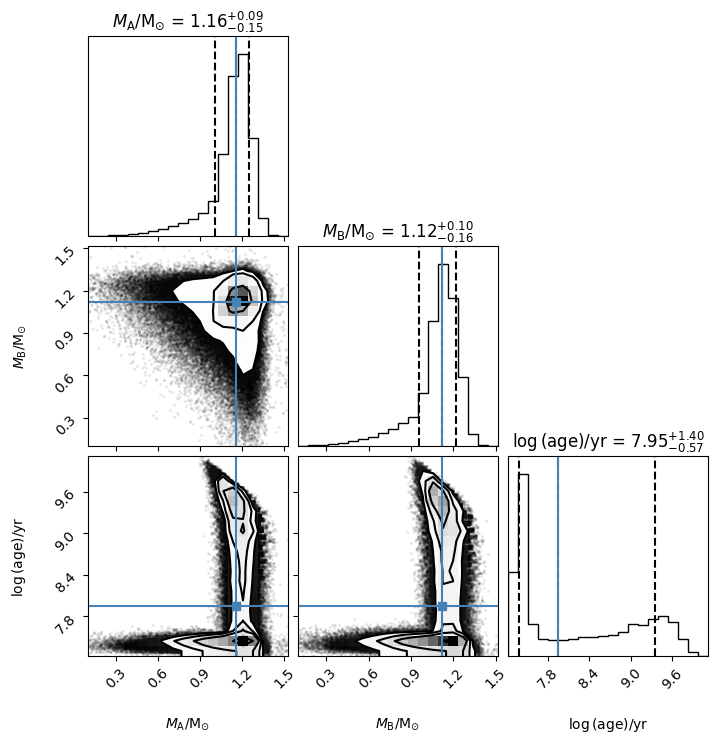

In [39]:
mass_plot_labels = np.array([f"$M_{{\\rm {subs[st]}}} / {{\\rm M_{{\\odot}}}}$" for st in range(NUM_STARS)] \
                            +["$\\log{{({{\\rm age}})}} / {{\\rm yr}}$"])

mass_fit_labels = np.array([(f"M{subs[st]}", u.Msun) for st in range(NUM_STARS)] \
                        +[("log(age)", u.dex(u.yr))])

plt.show(corner.corner(data=samples_from_sampler(mass_sampler, thin_by=thin_by, flat=True),
                       show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                       labels=mass_plot_labels, truths=nominal_values(mass_mcmc_theta)))

In [40]:
print(f"Parameters for {target} with nominals & 1-sigma uncertainties from MCMC fit ([known value])")
for (k, unit), theta_val in zip(mass_fit_labels, mass_mcmc_theta):
    known = ""
    if target_config.get("labels", {}).get(k, None) is not None:
        value = ufloat(target_config.labels.get(k, np.NaN), target_config.labels.get(k + "_err", 0))
        known = f"({value:.3f} {unit:unicode})"
    print(f"{k:>12s} = {theta_val:.3f} {unit:unicode} \t", known)
    target_meta[k] = theta_val

Parameters for HP Dra with nominals & 1-sigma uncertainties from MCMC fit ([known value])
          MA = 1.159+/-0.120 M☉ 	 (1.135+/-0.002 M☉)
          MB = 1.117+/-0.130 M☉ 	 (1.098+/-0.002 M☉)
    log(age) = 7.954+/-0.984 dex(yr) 	 


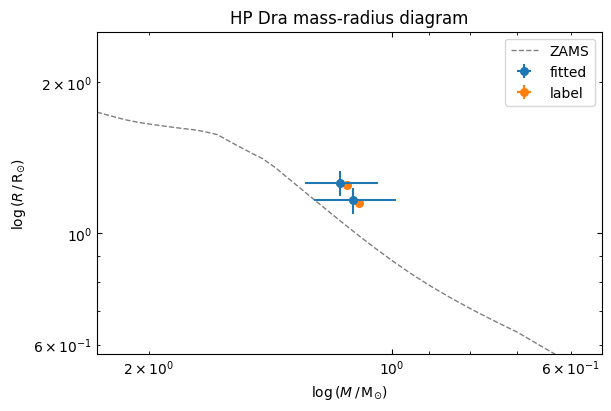

In [41]:
pub_vals = target_config.get("labels")
masses = np.array([[target_meta["MA"], target_meta["MB"]],
                   [ufloat(pub_vals["MA"], pub_vals["MA_err"]), ufloat(pub_vals["MB"], pub_vals["MB_err"])]])
radii = np.array([[target_meta["RA"], target_meta["RB"]],
                  [ufloat(pub_vals["RA"], pub_vals["RA_err"]), ufloat(pub_vals["RB"], pub_vals["RB_err"])]])

_lim_factor = 2
xlim = (np.max(nominal_values(masses))*_lim_factor, np.min(nominal_values(masses))/_lim_factor)
ylim = (np.min(nominal_values(radii))/_lim_factor, np.max(nominal_values(radii))*_lim_factor)
fig = plots.plot_mass_radius_hr_diagram(masses, radii, labels=["fitted", "label"], plot_zams=True,
                                        legend_loc="best", title=f"{target} mass-radius diagram",
                                        invertx=True, xlim=xlim, ylim=ylim)
plt.show(fig)